In [1]:
import torch

In [2]:
import numpy as np
import os
from matplotlib import pyplot as plt

In [3]:

background = np.load(os.path.join('~/GW3_AnomalyDetection/background.npz'))['data']
sglf = np.load(os.path.join('~/Desktop/GW3_AnomalyDetection/sglf_for_challenge.npy'))
bbh = np.load(os.path.join('~/Desktop/GW3_AnomalyDetection/bbh_for_challenge.npy'))

In [4]:
signal = np.concatenate((sglf, bbh), axis=0)

anomaly_class = {'noise': 0,'signal': 1}

background_ids = np.full(background.shape[0], anomaly_class['noise'], dtype=int)
signal_ids = np.full(signal.shape[0], anomaly_class['signal'], dtype=int)

x_data = np.concatenate((background, signal), axis=0).reshape((-1,200,2))
y_data = np.concatenate((background_ids, signal_ids), axis=0)

In [5]:

print(x_data.shape)
print(y_data.shape)

(300000, 200, 2)
(300000,)


In [6]:
300000/2

150000.0

In [7]:
#Scaling data 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num, points, depth = x_data.shape
flattened_data = x_data.reshape(num, -1)
scaled_data = scaler.fit_transform(flattened_data).reshape(num, points, depth)

print(scaled_data.shape)



(300000, 200, 2)


In [8]:
#Shuffeling data 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
scaled_data, y_data = shuffle(scaled_data, y_data, random_state=47)
scaled_data = scaled_data
y_data = y_data

In [9]:

print(y_data[:100])

[0 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0
 0 1 1 1 1 1 1 1 0 1 0 1 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 1 0 0 0 0 1 1 1
 0 0 1 1 0 0 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 0 1 1 1 0]


In [10]:
#Data Augmentation
noise_factor = 0.2
noise = np.random.randn(*scaled_data.shape) * noise_factor
augmented_data = scaled_data + noise

In [11]:


#Splitting data

train_x, val_x, train_y, val_y = train_test_split(scaled_data, y_data, test_size=0.3, random_state=13)

print(train_x.shape, train_y.shape)
print(val_x.shape, val_y.shape)

(210000, 200, 2) (210000,)
(90000, 200, 2) (90000,)


In [12]:
# Reshaping data for tensors
train_x = torch.tensor(train_x, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.float32).unsqueeze(1)

val_x = torch.tensor(val_x, dtype=torch.float32)
val_y = torch.tensor(val_y, dtype=torch.float32).unsqueeze(1)
print(train_x.shape, train_y.shape)
print(val_x.shape, val_y.shape)

torch.Size([210000, 200, 2]) torch.Size([210000, 1])
torch.Size([90000, 200, 2]) torch.Size([90000, 1])


In [13]:
batchSize = 1000

train_batches_x = torch.split(train_x, batchSize)
train_batches_y = torch.split(train_y, batchSize)
batch_split_num = len(train_batches_x)

#Splitting validation so model doesn't overload itself when checking val_accuracy

val_batches_x = torch.split(val_x, batchSize)
val_batches_y = torch.split(val_y, batchSize)

val_batch_split = len(val_batches_x)



In [14]:
print(batch_split_num)

210


In [15]:
print(train_batches_x[0].shape)

torch.Size([1000, 200, 2])


MODEL Defining

In [16]:
#Deeper learning and allows model to keep connections
class ResidualBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.layer1 = torch.nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.layer2 = torch.nn.BatchNorm1d(out_channels)
        self.relu = torch.nn.ReLU()
        self.layer3 = torch.nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)
        self.layer4 = torch.nn.BatchNorm1d(out_channels)

        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = torch.nn.Sequential(
                torch.nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride),
                torch.nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        identity = x  

        
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.relu(out)

       
        out = self.layer3(out)
        out = self.layer4(out)

        
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


In [17]:

#Make sure to run RB
class AttentionModel(torch.nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads):
        super(AttentionModel, self).__init__()
        self.layer1 = torch.nn.Conv1d(input_dim, 1024, kernel_size=1)
        self.layer2 = torch.nn.BatchNorm1d(1024)
        self.layer2_activation = torch.nn.ReLU()
        self.dropOut1 = torch.nn.Dropout(0.15)

        self.res_block1 = ResidualBlock(1024, 1024)  # Residual block 1

        self.layer4 = torch.nn.Conv1d(1024, 512, kernel_size=1)
        self.layer5 = torch.nn.BatchNorm1d(512)
        self.layer5_activation = torch.nn.ReLU()
        self.dropOut2 = torch.nn.Dropout(0.15)

        self.res_block2 = ResidualBlock(512, 512)  

        self.layer6 = torch.nn.Conv1d(512, 256, kernel_size=1)
        self.layer7 = torch.nn.BatchNorm1d(256)
        self.layer7_activation = torch.nn.ReLU()
        self.dropOut3 = torch.nn.Dropout(0.15)

        #self.res_block3 = ResidualBlock(256, 256)
        """
        self.layer65 = torch.nn.Conv1d(256, 128, kernel_size=1)
        self.layer75 = torch.nn.BatchNorm1d(128)
        self.layer75_activation = torch.nn.ReLU()
        self.dropOut4 = torch.nn.Dropout(0.15)
        """
        self.global_avg_pool = torch.nn.AdaptiveAvgPool1d(1)

        self.attention = torch.nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads)

        self.layer8 = torch.nn.Linear(128*2, 64*2)
        self.layer8_activation = torch.nn.ReLU()
        self.dropOut4 = torch.nn.Dropout(0.15)

        self.fc1 = torch.nn.Linear(64*2, 32*2)
        self.fc1_activation = torch.nn.ReLU()
        self.fc1_dropout = torch.nn.Dropout(0.15)

        self.fc2 = torch.nn.Linear(32*2, 16*2)
        self.fc2_activation = torch.nn.ReLU()
        self.fc2_dropout = torch.nn.Dropout(0.15)
        self.attention = torch.nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads)
        self.layerFinal = torch.nn.Linear(16*2, 1)

    def forward(self, x):

        
        #print("Begin")
        
        out = self.layer1(x)
        #print("first layer")
        out = self.layer2(out)
        out = self.layer2_activation(out)
        out = self.dropOut1(out)
        #print("first block")

        out = self.res_block1(out)  
        #print("Residual layer")
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer5_activation(out)
        out = self.dropOut2(out)
        #print("Sec block")
        out = self.res_block2(out)  

        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer7_activation(out)
        out = self.dropOut3(out)
        """
        out = self.res_block3(out)

        out = self.layer65(out)
        out = self.layer75(out)
        out = self.layer75_activation(out)
        out = self.dropOut4(out)
        """


        out = self.global_avg_pool(out)
        out = out.view(out.size(0), -1)
        #print("Past pooling")
       
        out = out.unsqueeze(0)  
        attn_output, _ = self.attention(out, out, out) 
        out = attn_output.squeeze(0)  # [batch_size, feature_dim]
        #print("Past attention")
        out = self.layer8(out)
        out = self.layer8_activation(out)
        out = self.dropOut4(out)

        out = self.fc1(out)
        out = self.fc1_activation(out)
        out = self.fc1_dropout(out)

        out = self.fc2(out)
        out = self.fc2_activation(out)
        out = self.fc2_dropout(out)
        #print("Past interconnected")
        out = torch.nn.functional.sigmoid(self.layerFinal(out))
        return out

In [20]:
#Better loss #ENDED UP NOT USING
import torch.nn as nn


class CustomBCELoss(nn.Module):
    def __init__(self, penalty_factor):
        super(CustomBCELoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.penalty_factor = penalty_factor

    def forward(self, outputs, targets):
        bce_loss = self.bce_loss(outputs, targets)
        probs = torch.sigmoid(outputs)
        penalty = self.penalty_factor * torch.mean((probs - 0.5).abs())
        total_loss = bce_loss + penalty
        
        return total_loss


In [21]:
epochs = 5
lr = 0.0001

model = AttentionModel(train_x.shape[1], 256, 64)
#model = RNNWithAttention(2, 1024, 1, 2, 0.15)

loss_func = torch.nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
#Helps make an adaptive learning rate
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


In [22]:
train_loss = []
train_acc = []
val_acc = []
val_loss = []
correct = 0

In [23]:
clip_value = 1.0
for epoch in range(epochs):
    model.train()
    for k in range(batch_split_num):
        optimizer.zero_grad()
        
        train_outputs = model(train_batches_x[k])
        
        
        loss = loss_func(train_outputs, train_batches_y[k])

       
        loss.backward()
        #Prevents exploding gradients 
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()
        predictions = (train_outputs >= 0.5).float()
        for v in range(len(train_outputs)):
            if predictions[v] == train_batches_y[k][v]:
                correct += 1    

        
    


    #print(train_outputs[:8].view(-1))
    #print(train_batches_y[-1][:8].view(-1))
    train_loss.append(loss.item())
    scheduler.step()
    total = train_y.shape[0]
    accuracy = correct / total
    train_acc.append(accuracy)
    correct = 0
    #print('epoch {}, loss {}'.format(epoch, loss.item()))
   
    #print("Got through training step")
    with torch.no_grad():
        model.eval()
        correct = 0
        total = val_y.shape[0]

        for j in range(val_batch_split):
            val_out = model(val_batches_x[j])
            predictions = (val_out >= 0.5).float()
            val_lose = loss_func(val_out, val_batches_y[j])


            for c in range(len(val_out)):
                if predictions[c] == val_batches_y[j][c]:
                    correct += 1
        
        accuracy = correct / total
        val_acc.append(accuracy)
        val_loss.append(val_lose.item())

    print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_lose.item()}, Val Acc: {accuracy:.4f}')

Epoch [1/5], Train Loss: 0.0763, Val Loss: 0.0748685970902443, Val Acc: 0.9745
Epoch [2/5], Train Loss: 0.0311, Val Loss: 0.06610095500946045, Val Acc: 0.9736
Epoch [3/5], Train Loss: 0.0322, Val Loss: 0.049230676144361496, Val Acc: 0.9770
Epoch [4/5], Train Loss: 0.0157, Val Loss: 0.05268125981092453, Val Acc: 0.9839
Epoch [5/5], Train Loss: 0.0116, Val Loss: 0.035097140818834305, Val Acc: 0.9813


In [24]:
from sklearn.metrics import precision_recall_curve

# Assuming `outputs` are the predicted probabilities and `y_true` are the true labels
precision, recall, thresholds = precision_recall_curve(val_batches_y[-1], val_out)

# Calculate F1 score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]

print(f'Best Threshold: {best_threshold}')

# Use the optimal threshold for predictions
predicted = (val_out >= best_threshold).float()


Best Threshold: 0.7881144881248474


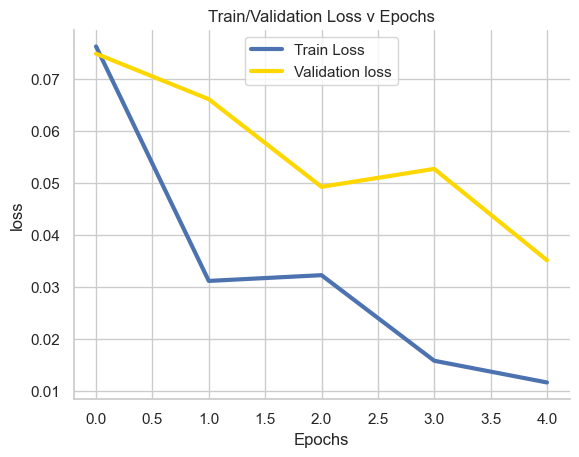

In [35]:

import seaborn as sns

sns.set(style = 'whitegrid', font_scale = 1)



plt.plot(train_loss, linewidth = 3, label='Train Loss')
plt.plot(val_loss, linewidth = 3, color = 'gold', label='Validation loss')
plt.legend(loc='upper center')
plt.title("Train/Validation Loss v Epochs")
plt.ylabel("loss")
plt.xlabel("Epochs")
sns.despine()



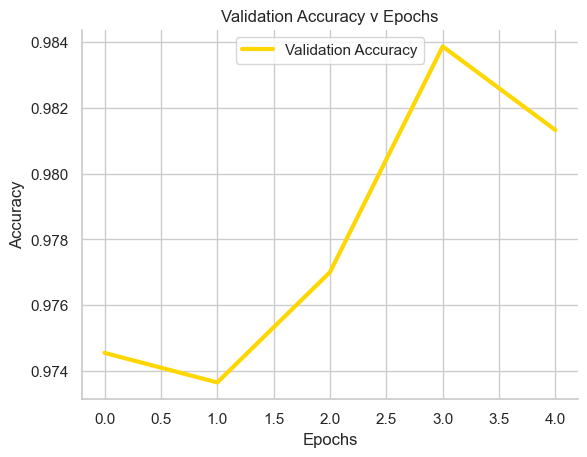

In [34]:


plt.plot(val_acc, linewidth = 3, color = 'gold', label='Validation Accuracy')
plt.legend(loc='upper center')
plt.title("Validation Accuracy v Epochs")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
sns.despine()